In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [12]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (6000, 12)
Test shape: (2523, 11)


In [13]:
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,8.23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,6.09
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,7.65
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,6.60
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,6.90


## Check Data Types

In [14]:
print("Data Types:")
print(df_train.dtypes)

Data Types:
X1      object
X2     float64
X3      object
X4     float64
X5      object
X6     float64
X7      object
X8       int64
X9      object
X10     object
X11     object
Y      float64
dtype: object


In [15]:
print("Missing Values (%):\n")
missing_pct = df_train.isnull().sum() / len(df_train) * 100
print(missing_pct[missing_pct > 0])

Missing Values (%):

X2    16.766667
X9    28.516667
dtype: float64


In [16]:
print("Target Variable (Y) Statistics:\n")
print(df_train['Y'].describe())

Target Variable (Y) Statistics:

count    6000.000000
mean        7.303403
std         1.014361
min         3.510000
25%         6.750000
50%         7.500000
75%         8.040000
max         9.400000
Name: Y, dtype: float64


In [17]:
print("X3 values:", df_train['X3'].unique())
print("\nX3 value counts:")
print(df_train['X3'].value_counts())

X3 values: ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

X3 value counts:
X3
Low Fat    3595
Regular    2030
LF          220
reg          81
low fat      74
Name: count, dtype: int64


## Define Preprocessing Function

In [18]:
def preprocess_data(df, is_train=True):
    """
    Preprocess the dataframe:
    - Drop ID column (X1)
    - Standardize categorical values
    - Handle missing values
    - Remove duplicates (training only)
    """
    df = df.copy()
    
    # Drop X1 (ID column)
    if 'X1' in df.columns:
        df = df.drop('X1', axis=1)
        print("  ✓ Dropped X1")
    
    # Standardize X3 values
    if 'X3' in df.columns:
        df['X3'] = df['X3'].replace({
            'low fat': 'Low Fat', 
            'LF': 'Low Fat', 
            'reg': 'Regular'
        })
        print("  ✓ Standardized X3")
    
    # Handle X9 - Fill with mode (RECOMMENDED)
    if 'X9' in df.columns:
        df['X9'] = df['X9'].fillna('Medium')
        print("  ✓ Filled X9 missing values")
    
    # Fill X2 missing values
    if 'X2' in df.columns:
        mean_x2 = df['X2'].mean()
        df['X2'] = df['X2'].fillna(mean_x2)
        print(f"  ✓ Filled X2 with mean: {mean_x2:.2f}")
    
    # Remove duplicates (training only)
    if is_train:
        initial_rows = len(df)
        df = df.drop_duplicates()
        removed = initial_rows - len(df)
        if removed > 0:
            print(f"  ✓ Removed {removed} duplicates")
    
    return df

## Apply Preprocessing

In [19]:
print("Preprocessing Training Data:")
df_train_processed = preprocess_data(df_train, is_train=True)

print("\nPreprocessing Test Data:")
df_test_processed = preprocess_data(df_test, is_train=False)

print(f"\nFinal shapes:")
print(f"Train: {df_train_processed.shape}")
print(f"Test: {df_test_processed.shape}")
print(f"Missing values: {df_train_processed.isnull().sum().sum()}")

Preprocessing Training Data:
  ✓ Dropped X1
  ✓ Standardized X3
  ✓ Filled X9 missing values
  ✓ Filled X2 with mean: 12.96

Preprocessing Test Data:
  ✓ Dropped X1
  ✓ Standardized X3
  ✓ Filled X9 missing values
  ✓ Filled X2 with mean: 12.62

Final shapes:
Train: (6000, 11)
Test: (2523, 10)
Missing values: 0


In [20]:
def engineer_features(df):
    """
    Create new features:
    - Store age
    - Visibility categories
    - Price categories
    - Interaction features
    """
    df = df.copy()
    
    # Store age
    if 'X8' in df.columns:
        df['X8_Age'] = 2025 - df['X8']
        print("  ✓ Created X8_Age")
    
    # Visibility features
    if 'X4' in df.columns:
        df['X4_IsZero'] = (df['X4'] == 0).astype(int)
        df['X4_Category'] = pd.cut(df['X4'], 
                                     bins=[-0.001, 0, 0.05, 0.1, 1.0],
                                     labels=['Zero', 'Low', 'Medium', 'High'])
        print("  ✓ Created X4 features")
    
    # Price categories
    if 'X2' in df.columns:
        df['X2_Category'] = pd.cut(df['X2'], 
                                     bins=[0, 10, 15, 20, 100],
                                     labels=['Low', 'Medium', 'High', 'Very High'])
        print("  ✓ Created X2_Category")
    
    # Interaction
    if 'X2' in df.columns and 'X6' in df.columns:
        df['X2_X6_Interaction'] = df['X2'] * df['X6']
        print("  ✓ Created X2_X6_Interaction")
    
    return df

In [21]:
print("Engineering features for training data:")
df_train_processed = engineer_features(df_train_processed)

print("\nEngineering features for test data:")
df_test_processed = engineer_features(df_test_processed)

print(f"\nNew shapes:")
print(f"Train: {df_train_processed.shape}")
print(f"Test: {df_test_processed.shape}")

Engineering features for training data:
  ✓ Created X8_Age
  ✓ Created X4 features
  ✓ Created X2_Category
  ✓ Created X2_X6_Interaction

Engineering features for test data:
  ✓ Created X8_Age
  ✓ Created X4 features
  ✓ Created X2_Category
  ✓ Created X2_X6_Interaction

New shapes:
Train: (6000, 16)
Test: (2523, 15)


In [22]:
print("Sample of engineered features:")
df_train_processed[['X8', 'X8_Age', 'X4', 'X4_IsZero', 'X2', 'X2_Category', 'X2_X6_Interaction']].head()

Sample of engineered features:


,X8,X8_Age,X4,X4_IsZero,X2,X2_Category,X2_X6_Interaction
0,1999,26,0.016047,0,9.30,Low,2323.225560
1,2009,16,0.019278,0,5.92,Low,285.753664
2,1999,26,0.016760,0,17.50,High,2478.315000
3,1998,27,0.000000,1,19.20,High,3496.224000
4,1987,38,0.000000,1,8.93,Low,480.982302


In [23]:
categorical_cols = df_train_processed.select_dtypes(include=['object', 'category']).columns.tolist()

if 'Y' in categorical_cols:
    categorical_cols.remove('Y')

print(f"Categorical columns: {categorical_cols}")
print(f"Total: {len(categorical_cols)} columns")

Categorical columns: ['X3', 'X5', 'X7', 'X9', 'X10', 'X11', 'X4_Category', 'X2_Category']
Total: 8 columns


In [24]:
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    
    # Fit on training data
    df_train_processed[col] = le.fit_transform(df_train_processed[col].astype(str))
    encoders[col] = le
    
    # Transform test data (handle unseen labels)
    df_test_processed[col] = df_test_processed[col].astype(str)
    df_test_processed[col] = df_test_processed[col].apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    
    print(f"  ✓ Encoded {col}: {len(le.classes_)} values")

print("\n✓ All categorical variables encoded!")

  ✓ Encoded X3: 2 values
  ✓ Encoded X5: 16 values
  ✓ Encoded X7: 10 values
  ✓ Encoded X9: 3 values
  ✓ Encoded X10: 3 values
  ✓ Encoded X11: 4 values
  ✓ Encoded X4_Category: 4 values
  ✓ Encoded X2_Category: 4 values

✓ All categorical variables encoded!


In [25]:
print("Missing values after encoding:")
print(f"Train: {df_train_processed.isnull().sum().sum()}")
print(f"Test: {df_test_processed.isnull().sum().sum()}")

Missing values after encoding:
Train: 0
Test: 0


In [26]:
X = df_train_processed.drop('Y', axis=1)
y = df_train_processed['Y']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")

Features shape: (6000, 15)
Target shape: (6000,)
Number of features: 15


In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")

Training: 4800 samples (80.0%)
Validation: 1200 samples (20.0%)


In [30]:
results = {}

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(
        n_estimators=200, 
        max_depth=15,
        min_samples_split=5,
        random_state=42, 
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )
}

print(f"Will train {len(models)} models...")

Will train 5 models...


In [31]:
for i, (model_name, model) in enumerate(models.items(), 1):
    print(f"[{i}/{len(models)}] Training {model_name}...")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    val_mae = mean_absolute_error(y_val, y_pred_val)
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, 
                                 cv=5, 
                                 scoring='neg_mean_squared_error',
                                 n_jobs=-1)
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Store results
    results[model_name] = {
        'model': model,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'cv_rmse': cv_rmse,
        'predictions': y_pred_val
    }
    
    print(f"  Train RMSE: {train_rmse:.4f} | Val RMSE: {val_rmse:.4f} | CV RMSE: {cv_rmse:.4f}")
    print(f"  Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}\n")

print("✓ All models trained!")

[1/5] Training Linear Regression...
  Train RMSE: 0.6389 | Val RMSE: 0.6635 | CV RMSE: 0.6412
  Train R²: 0.5988 | Val R²: 0.5900

[2/5] Training Ridge Regression...
  Train RMSE: 0.6398 | Val RMSE: 0.6635 | CV RMSE: 0.6423
  Train R²: 0.5975 | Val R²: 0.5900

[3/5] Training Lasso Regression...
  Train RMSE: 0.6895 | Val RMSE: 0.7112 | CV RMSE: 0.6907
  Train R²: 0.5326 | Val R²: 0.5289

[4/5] Training Random Forest...
  Train RMSE: 0.3025 | Val RMSE: 0.5606 | CV RMSE: 0.5433
  Train R²: 0.9100 | Val R²: 0.7073

[5/5] Training Gradient Boosting...
  Train RMSE: 0.4400 | Val RMSE: 0.5500 | CV RMSE: 0.5341
  Train R²: 0.8096 | Val R²: 0.7183

✓ All models trained!


In [32]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Val RMSE': [results[m]['val_rmse'] for m in results.keys()],
    'Val MAE': [results[m]['val_mae'] for m in results.keys()],
    'Val R²': [results[m]['val_r2'] for m in results.keys()],
    'CV RMSE': [results[m]['cv_rmse'] for m in results.keys()],
    'Train RMSE': [results[m]['train_rmse'] for m in results.keys()],
})

comparison_df = comparison_df.sort_values('Val RMSE')
comparison_df


,Model,Val RMSE,Val MAE,Val R²,CV RMSE,Train RMSE
4,Gradient Boosting,0.550004,0.420423,0.718263,0.534050,0.440033
3,Random Forest,0.560564,0.430654,0.707340,0.543298,0.302526
1,Ridge Regression,0.663453,0.518012,0.590048,0.642280,0.639843
0,Linear Regression,0.663492,0.518511,0.590000,0.641237,0.638858
2,Lasso Regression,0.711232,0.556665,0.528876,0.690705,0.689538


In [33]:
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print("="*60)
print(f"🏆 BEST MODEL: {best_model_name}")
print("="*60)
print(f"Validation RMSE: {results[best_model_name]['val_rmse']:.4f}")
print(f"Validation R²: {results[best_model_name]['val_r2']:.4f}")
print(f"Cross-Val RMSE: {results[best_model_name]['cv_rmse']:.4f}")
print("="*60)

🏆 BEST MODEL: Gradient Boosting
Validation RMSE: 0.5500
Validation R²: 0.7183
Cross-Val RMSE: 0.5341


In [34]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"Top 10 Features for {best_model_name}:\n")
    print(feature_importance.head(10).to_string(index=False))
else:
    print(f"Feature importance not available for {best_model_name}")

Top 10 Features for Gradient Boosting:

          Feature  Importance
              X11    0.538433
               X6    0.369084
X2_X6_Interaction    0.021100
               X4    0.017637
               X8    0.014960
               X2    0.011844
           X8_Age    0.010188
               X5    0.006079
               X7    0.003984
              X10    0.002201


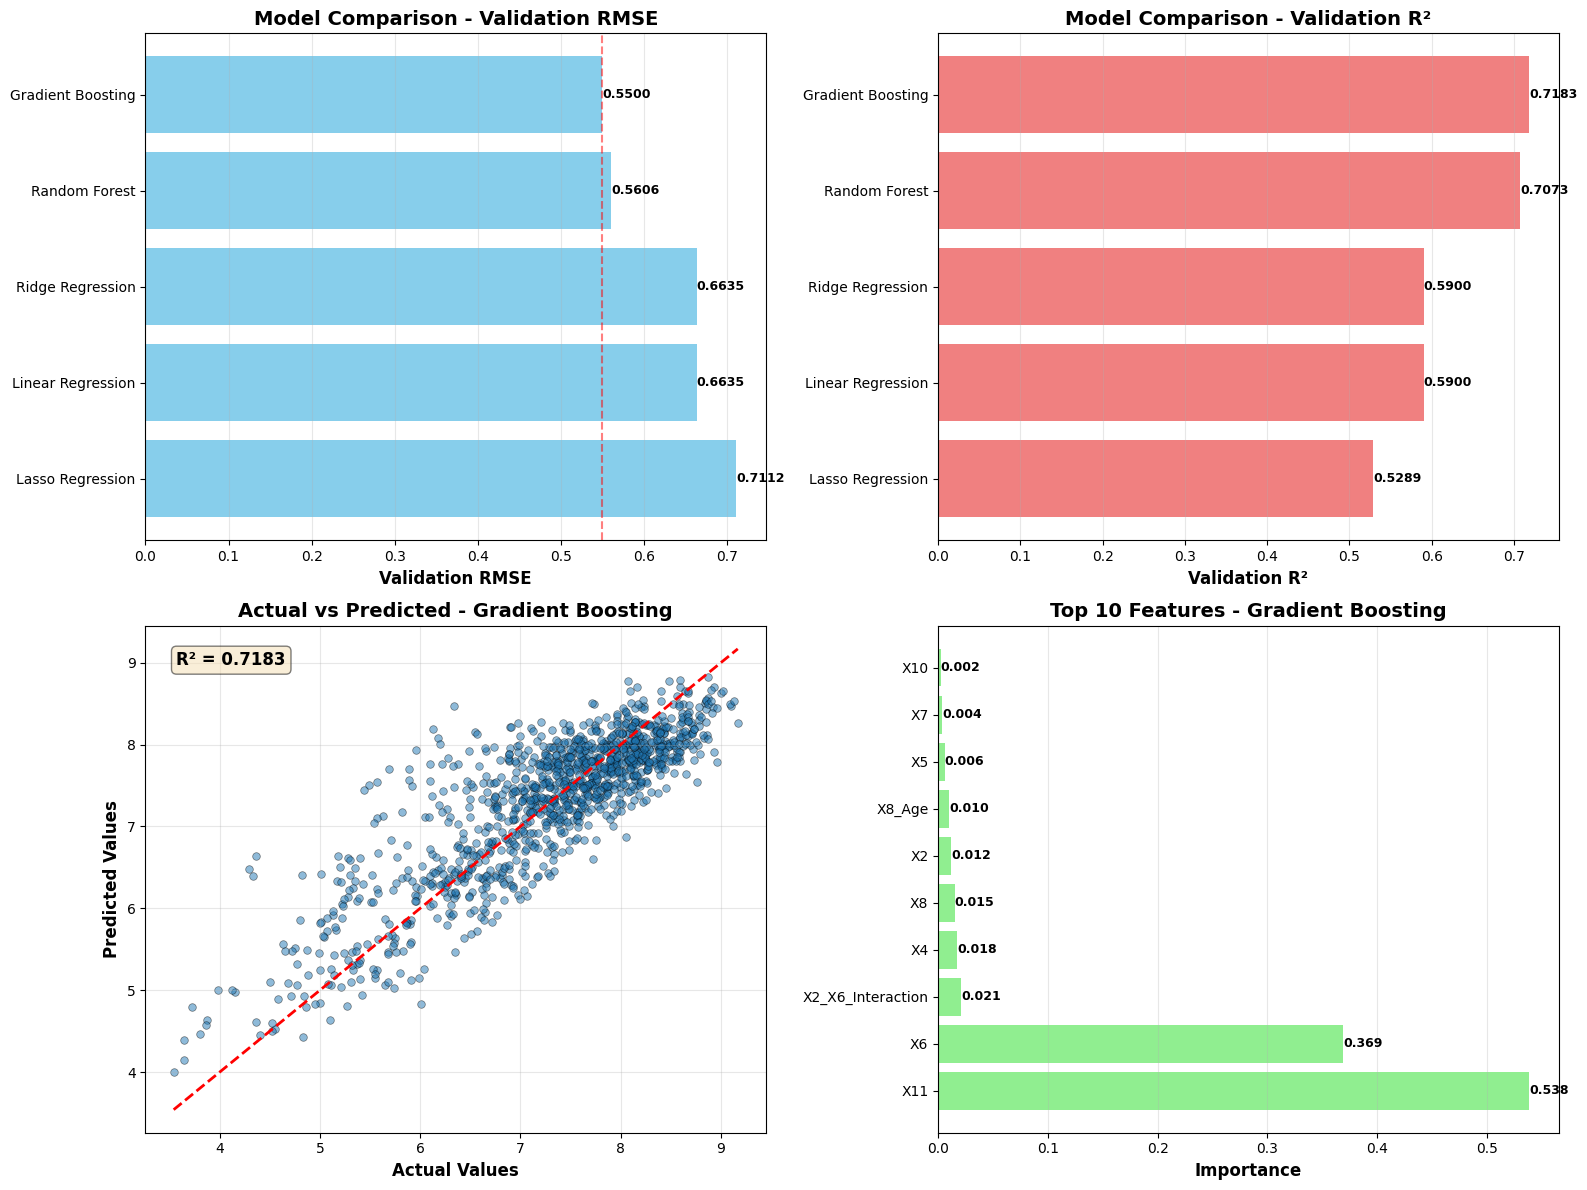


✓ Visualizations created!


In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Model Comparison - RMSE
ax1 = axes[0, 0]
comparison_sorted = comparison_df.sort_values('Val RMSE', ascending=False)
bars = ax1.barh(comparison_sorted['Model'], comparison_sorted['Val RMSE'], color='skyblue')
ax1.axvline(x=comparison_sorted['Val RMSE'].min(), color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Validation RMSE', fontsize=12, fontweight='bold')
ax1.set_title('Model Comparison - Validation RMSE', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center', fontsize=9, fontweight='bold')

# 2. Model Comparison - R²
ax2 = axes[0, 1]
comparison_sorted_r2 = comparison_df.sort_values('Val R²', ascending=True)
bars = ax2.barh(comparison_sorted_r2['Model'], comparison_sorted_r2['Val R²'], color='lightcoral')
ax2.set_xlabel('Validation R²', fontsize=12, fontweight='bold')
ax2.set_title('Model Comparison - Validation R²', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center', fontsize=9, fontweight='bold')

# 3. Actual vs Predicted
ax3 = axes[1, 0]
y_pred_best = results[best_model_name]['predictions']
ax3.scatter(y_val, y_pred_best, alpha=0.5, s=30, edgecolors='black', linewidths=0.5)
ax3.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Values', fontsize=12, fontweight='bold')
ax3.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
ax3.set_title(f'Actual vs Predicted - {best_model_name}', fontsize=14, fontweight='bold')
ax3.grid(alpha=0.3)

r2_text = f'R² = {results[best_model_name]["val_r2"]:.4f}'
ax3.text(0.05, 0.95, r2_text, transform=ax3.transAxes, 
         fontsize=12, verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Feature Importance
ax4 = axes[1, 1]
if hasattr(best_model, 'feature_importances_'):
    top_features = feature_importance.head(10)
    bars = ax4.barh(top_features['Feature'], top_features['Importance'], color='lightgreen')
    ax4.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax4.set_title(f'Top 10 Features - {best_model_name}', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    
    for bar in bars:
        width = bar.get_width()
        ax4.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
                 ha='left', va='center', fontsize=9, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'Feature importance\nnot available', 
             ha='center', va='center', fontsize=14, fontweight='bold')
    ax4.axis('off')

plt.tight_layout()
plt.savefig('model_evaluation_improved.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations created!")

In [36]:
test_predictions = best_model.predict(df_test_processed)

print(f"Predictions: {len(test_predictions)}")
print(f"Range: [{test_predictions.min():.2f}, {test_predictions.max():.2f}]")
print(f"Mean: {test_predictions.mean():.2f}")
print(f"Std: {test_predictions.std():.2f}")

Predictions: 2523
Range: [3.68, 8.98]
Mean: 7.28
Std: 0.88


In [37]:
sub_example = pd.read_csv("sample_submission.csv")

submission = pd.DataFrame({
    "row_id": sub_example["row_id"],  
    "Y": test_predictions  
})

submission.to_csv("submission_improved.csv", index=False)
print("✓ Submission saved: submission_improved.csv")

print("\nFirst 10 predictions:")
submission.head(10)

✓ Submission saved: submission_improved.csv

First 10 predictions:


,row_id,Y
0,0,8.614684
1,1,6.971569
2,2,6.093181
3,3,6.854398
4,4,7.283122
5,5,7.678621
6,6,7.570977
7,7,7.895959
8,8,5.257888
9,9,8.050133


In [38]:
print("="*70)
print("PIPELINE SUMMARY")
print("="*70)
print(f"✓ Data preprocessed with feature engineering")
print(f"✓ Trained {len(models)} models")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Validation RMSE: {results[best_model_name]['val_rmse']:.4f}")
print(f"✓ Validation R²: {results[best_model_name]['val_r2']:.4f}")
print(f"✓ CV RMSE: {results[best_model_name]['cv_rmse']:.4f}")
print("="*70)
print("\nKEY IMPROVEMENTS:")
print("  1. Feature engineering (5 new features)")
print("  2. Multiple models (5 models)")
print("  3. Cross-validation")
print("  4. Optimized hyperparameters")
print("  5. Comprehensive visualizations")
print("  6. Feature importance analysis")
print("="*70)

PIPELINE SUMMARY
✓ Data preprocessed with feature engineering
✓ Trained 5 models
✓ Best model: Gradient Boosting
✓ Validation RMSE: 0.5500
✓ Validation R²: 0.7183
✓ CV RMSE: 0.5341

KEY IMPROVEMENTS:
  1. Feature engineering (5 new features)
  2. Multiple models (5 models)
  3. Cross-validation
  4. Optimized hyperparameters
  5. Comprehensive visualizations
  6. Feature importance analysis


In [39]:
# Save comparison and feature importance
comparison_df.to_csv('model_comparison_improved.csv', index=False)
print("✓ Model comparison saved")

if hasattr(best_model, 'feature_importances_'):
    feature_importance.to_csv('feature_importance_improved.csv', index=False)
    print("✓ Feature importance saved")

✓ Model comparison saved
✓ Feature importance saved
